# Housekeeping

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick

# Data Gathering - Calculating RSI and Bollinger Bands

In [27]:
TICKER = 'SPY'

RSI_LENGTH = 14
OVERBOUGHT = 60
OVERSOLD = 40
BB_LEN = 20
DEVS = 2
LOOKBACK = 1000

def get_data(ticker=TICKER, lookback=LOOKBACK):

    # get data at interval you want
    df = yf.download(ticker)
    df.columns = df.columns.get_level_values(0)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_RSI(df, length = RSI_LENGTH):
    price_change = df['Close'].diff()

    #Separate out gains and losses
    gain = price_change.where(price_change>0,0)
    loss = -price_change.where(price_change <0, 0)

    #average gains vs losses
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    #Relative Strength - what percentage of eachother have the gains and losses been
    rs = avg_gain/avg_loss

    rsi = 100 - (100/(1+rs))

    df['RSI'] = rsi

    #Plot RSI
    plt.figure(figsize=(12, 6))
    plt.plot(df['RSI'], label='RSI')
    plt.axhline(OVERBOUGHT, color='red', linewidth=1, linestyle='--', label = 'Overbought')
    plt.axhline(OVERSOLD, color='green', linewidth=1, linestyle='--', label = 'Oversold')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return df.dropna()

def add_bollinger_bands(df, devs=DEVS, bb_len=BB_LEN):

    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color='blue')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')

    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {DEVS}');

    return df


# Creating and Testing the Strategy

In [28]:
def add_RSI_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1, 
                     np.where(df['RSI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)
    return df

def add_BB_strategy(df):
    df['BB_Strategy'] = 0
    df['BB_Strategy'] = np.where(
        df['Close'] > df['Upper_Band'], -1, 
        np.where(df['Close'] < df['Lower_Band'], 1, 0)
        )
    
    df['BB_Strategy'] = df['BB_Strategy'].shift(1)
    
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['RSI_Strategy'] + df['BB_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure(figsize=(14, 7))
    plt.plot(df['Asset_Returns'],label=f'{TICKER} Buy & Hold', color='blue', linewidth=1.5)
    plt.plot(df['Strategy_Returns'], color='orange',linestyle='--', linewidth=1.5)
    plt.legend([f'{TICKER} Cumulative', 'Strategy Cumulative'])
    plt.title('Strategy vs. Market', size='20')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.6)    
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()
    return df

# Summarising Returns and Running the Code

C:\Users\EWD\AppData\Local\Temp\ipykernel_15716\3247026565.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker)
[*********************100%***********************]  1 of 1 completed


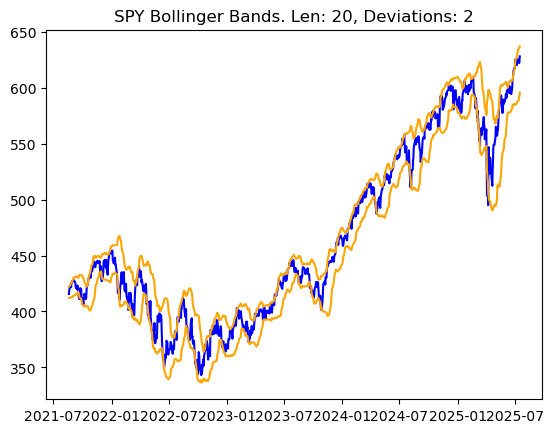

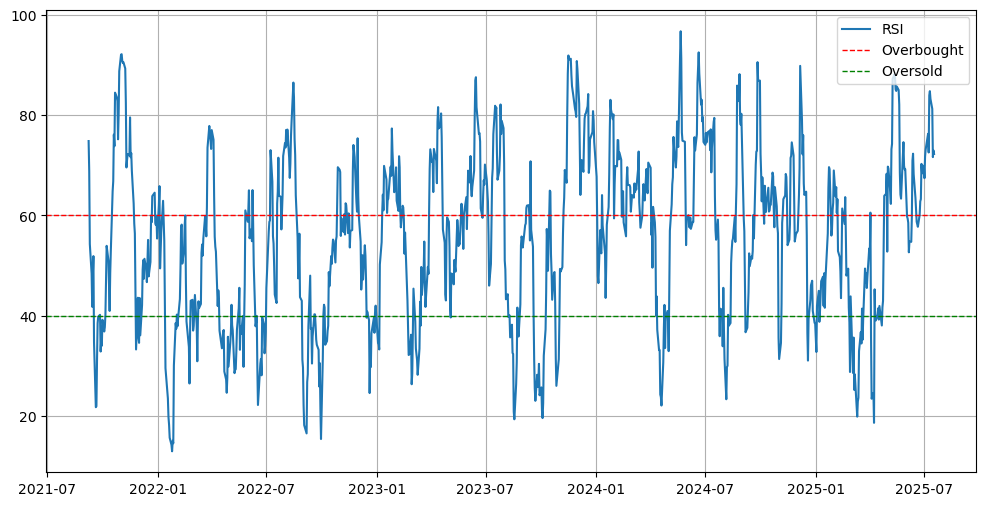

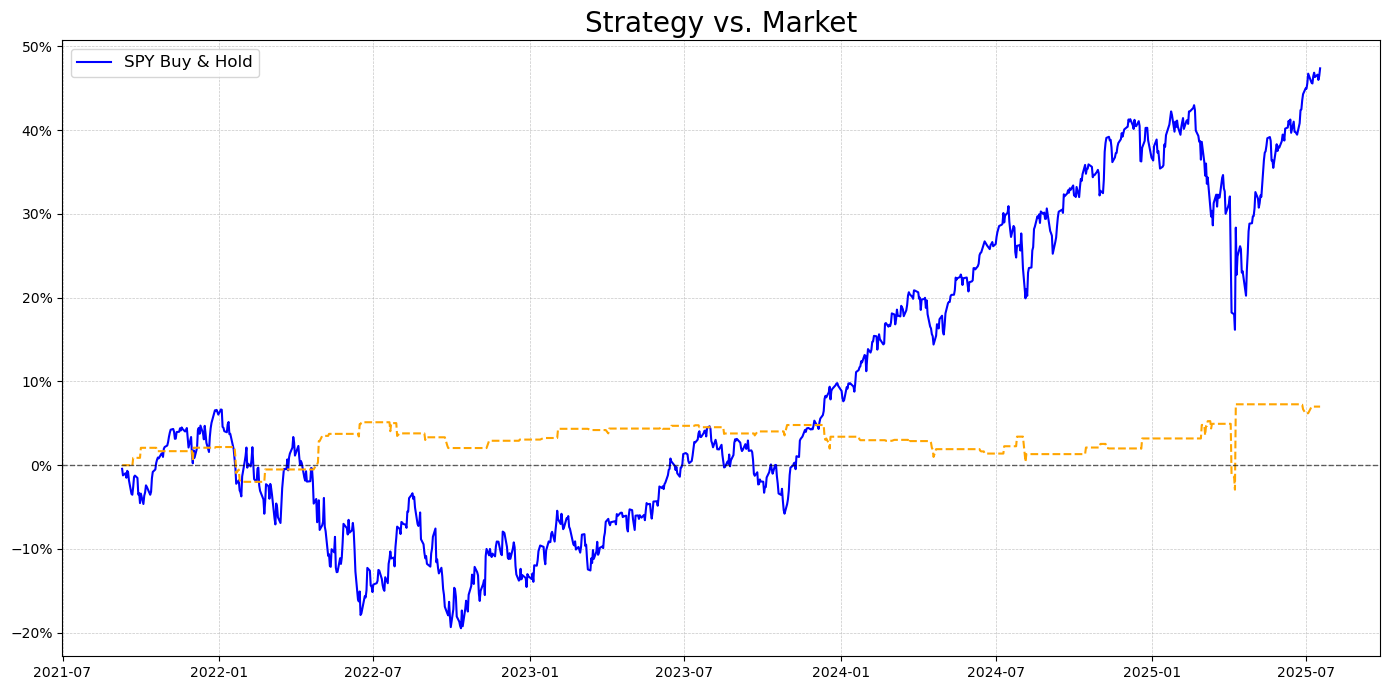

SPY Price Change: 47.39%
SPY Strategy Return: 7.00%


Price,Close,High,Low,Open,Volume,BB_SMA,BB_STD,Upper_Band,Lower_Band,RSI,BB_Strategy,RSI_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
Date,,,,,,,,,,,,,,,,
2021-09-08,426.104065,426.822264,424.166824,426.085176,56181900,423.028044,3.986229,431.000503,415.055585,74.831924,NaN,NaN,NaN,0,NaN,NaN
2021-09-09,424.280121,427.672619,424.034415,425.905499,57970400,423.273740,3.899135,431.072010,415.475470,68.858574,0.0,-1.0,-1.0,0,-0.004281,0.00000
2021-09-10,420.934906,426.652064,420.812053,426.226838,89948200,423.289334,3.888585,431.066504,415.512164,54.294065,0.0,-1.0,-1.0,0,-0.012131,0.00000
2021-09-13,422.012146,424.223440,419.678028,423.958845,83738600,423.320515,3.875017,431.070550,415.570481,48.415447,0.0,0.0,0.0,0,-0.009603,0.00000
2021-09-14,419.734741,423.675319,418.836992,423.467421,78197100,423.188216,3.953173,431.094562,415.281869,41.796079,0.0,0.0,0.0,0,-0.014948,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-11,623.619995,624.859985,621.530029,622.739990,63670200,611.024109,11.381472,633.787052,588.261165,83.235203,0.0,-1.0,-1.0,0,0.463539,0.06998
2025-07-14,624.809998,625.159973,621.799988,623.159973,51898500,612.166089,11.569512,635.305114,589.027064,81.246877,0.0,-1.0,-1.0,0,0.466332,0.06998
2025-07-15,622.140015,627.859985,622.059998,627.520020,74317300,613.511075,11.050210,635.611495,591.410655,71.633857,0.0,-1.0,-1.0,0,0.460066,0.06998


In [29]:

def return_summary(df, TICKER, LOOKBACK):
    asset_return = df['Asset_Returns'].iloc[-1] * 100
    strategy_return = df['Strategy_Returns'].iloc[-1] * 100
    print(f"{TICKER} Price Change: {asset_return:.2f}%")
    print(f"{TICKER} Strategy Return: {strategy_return:.2f}%")
    return df

def main():
    df = get_data()
    df = add_bollinger_bands(df)
    df = add_RSI(df)
    df = add_BB_strategy(df)
    df = add_RSI_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)
    return_summary(df, TICKER, LOOKBACK)  
    return df

main()